# 차원 축소
- 수 많은 특성들은 훈련을 느리게 만들 뿐만 아니라 솔루션을 찾기 힘들게 만드는데 이를 종종 '차원의 저주'라고 함 
- 차원을 축소시키면 일부 정보가 유실되는데 이는 성능을 감소시킬 수 있지만 훈련 속도는 빨라질 수 있음(어떤 경우에는 잡음이 제거되어 성능 향상)
- 차원 축소의 주요 접근 방법
    - 투영
    - 매니폴드 학습

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 8.1 차원의 저주
- 차원이 커질수록 점들은 경계에 위치할 가능성이 커지고 점 사이간 거리도 커짐
- 이는 훈련 샘플의 차원이 커질수록 새로운 샘플이 훈련 샘플과 멀리 떨어질 가능성이 높아지고 과대적합의 위험이 커짐
- 고차원의 차원의 저주를 피하려면 더 많은 훈련 샘플이 필요한데, 차원이 커질수록 필요한 훈련 샘플은 기하급수적으로 늘어남

## 8.2 차원 축소를 위한 접근 방법
- 차원을 감소시키는 주요한 접근법 두 가지는 투영과 매니폴드 학습

#### 8.2.1 투영
- 대부분의 실전문제는 훈련 샘플이 모든 차원에 균일하게 퍼져있지 않음 (즉, 고차원 공간 안의 저차원 부분 공간에 놓여 있음)

In [2]:
# 3D 데이터셋 생성
np.random.seed(4)
m = 60 # sample size
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3)) # 3차원 공간
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2 # x1축 값 결정
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2 # x2축 값 결정
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m) # x3축 값 결정

In [3]:
# 1. SVD 분해를 사용한 PCA
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered) # svd ==> 특이값 분해
c1 = Vt.T[:, 0] # 1번째 열
c2 = Vt.T[:, 1] # 2번째 열

In [4]:
U.shape, s.shape, Vt.shape # m*n의 A행렬에 대하여 특이값 분해(U=m*m, s=m*n, Vt=n*n)
# U => A*A^T(U의 열벡터들을 A의 좌측 특이 벡터라고 함) // s => 대각행렬 // Vt => A^T*A(Vt의 열벡터들을 우측 특이 벡터라고 함)
# U와 Vt는 직교 행렬(직교 행렬이란 자기자신과 자기자신의 전치(역행렬이됨)를 곱한 값이 1 // ex -> U*U^T=1, U^T=U^(-1))

((60, 60), (3,), (3, 3))

In [5]:
np.diag(s) # s의 경우 내림차순으로 졍렬되고 대각행렬이므로 변환이 필요(diag 이후 m*n으로 만들어야함)

array([[6.77645005, 0.        , 0.        ],
       [0.        , 2.82403671, 0.        ],
       [0.        , 0.        , 0.78116597]])

In [6]:
# 대각행렬 s 변환
m, n = X.shape # m=60, n=3

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [7]:
np.allclose(X_centered, U.dot(S).dot(Vt)) # allclose ==> 배열의 모든 요소가 허용 오차 이내에 있다면 True 반환

True

In [8]:
W2 = Vt.T[:, :2] # 모든행 and 2열까지
X2D = X_centered.dot(W2)

In [9]:
X2D_using_svd = X2D # 3차원 => 2차원
X2D_using_svd.shape, X_centered.shape

((60, 2), (60, 3))

In [10]:
# 2. 사이킷런을 이용한 PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [11]:
X2D[:5] # 사이킷런을 이용한 PCA

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [12]:
X2D_using_svd[:5] # SVD를 이용한 PCA

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [13]:
np.allclose(X2D, -X2D_using_svd) # 두 PCA는 동일한 결과

True

In [14]:
# 사이킷런을 이용한 평면(PCA 2D 부분공간)에 투영된 3D 점을 복원
X3D_inv = pca.inverse_transform(X2D)

In [15]:
np.allclose(X3D_inv, X) # 투영 단계에서 일부 정보를 잃어버리므로 완전히 똑같지는 않음

False

In [16]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1)) # 재구성 결과와 오차를 계산하면 매우 작은 수치

0.010170337792848549

In [17]:
# SVD를 이용한 평면(PCA 2D 부분공간)에 투영된 3D 점을 복원
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

In [18]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_) # 정보를 잃지 않고 똑같이 복원
# 사이킷런의 PCA 클래스는 자동으로 평균을 뺏던 것을 복원해주기 때문에 두 방식의 재구성 오차가 동일하지는 않음(평균을 빼면 동일한 재구성)

True

In [19]:
pca.components_ # 사이킷런 PCA 객체를 사용한 주성분 참조

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [20]:
Vt[:2] # SVD 방법으로 계산된 처음 두 개의 주성분 참조

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [21]:
pca.explained_variance_ratio_ # 사이킷런 방식의 주성분의 분산 비율 확인(제1 주성분 84.2%, 제2 주성분 14.6%)

array([0.84248607, 0.14631839])

In [22]:
1 - pca.explained_variance_ratio_.sum() # 2D로 투영했기 때문에 분산의 약 1.1%를 잃음

0.011195535570688975

In [23]:
np.square(s) / np.square(s).sum() # SVD 방식의 주성분 분산 비율 확인 ((제1 주성분 84.2%, 제2 주성분 14.6%, 제3 주성분 0.01%)

array([0.84248607, 0.14631839, 0.01119554])

In [24]:
# 3D 화살표를 그리기 위한 유틸리티 클래스(추후 이해 필요함...)
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [25]:
# x, y의 함수로 평면 표현
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10) # -1.8~1.8 구간을 10개로 나눔
x2s = np.linspace(axes[2], axes[3], 10) # -1.3~1.3 구간을 10개로 나눔
x1, x2 = np.meshgrid(x1s, x2s) # meshgrid ==> 두 배열의 가능한 조합을 모두 생성

C = pca.components_ # 제1~제2 주성분
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

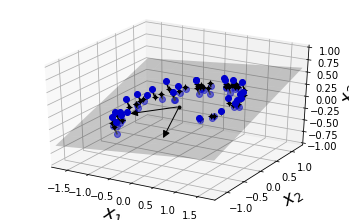

In [26]:
# 3D 데이터셋, 평면 그리고 이 평면으로의 투영 그래프 그리기(추후 이해 필요함...)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=4)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

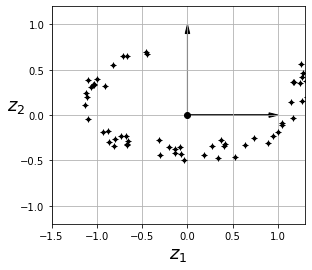

In [27]:
# 투영된 평면의 그래프 그리기
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

### 8.2.2 매니폴드 학습
- 스위스 롤이 대표적인 매니폴드의 한 예(간단하게 2D 매니폴드는 고차원 공간에서 휘어지거나 뒤틀린 2D의 모양)
- D차원 매니폴드는 D차원 초평면으로 보일 수 있는 N차원 공간의 일부(D<N)
- 많은 차원 축소 알고리즘이 훈련 샘플이 놓여 있는 매니폴드를 모델링하는 식으로 작동하며 이를 매니폴드 학습이라 함

In [28]:
from sklearn.datasets import make_swiss_roll # 스위스 롤

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42) # 샘플 1,000개 잡음 0.2로 생성

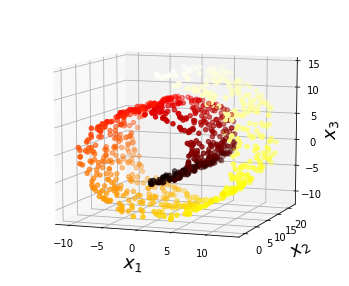

In [29]:
# 스위스 롤 3차원 그래프 그리기
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot) # 3차원 산점도
ax.view_init(10, -70) # view_init ==> 바라보는 시야 각도 설정
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7) # x축명 설정
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7) # y축명 설정
ax.set_zlabel("$x_3$", fontsize=18) # z축명 설정
ax.set_xlim(axes[0:2]) # x축 범위 설정
ax.set_ylim(axes[2:4]) # y축 범위 설정
ax.set_zlim(axes[4:6]) # z축 범위 설정
plt.show()

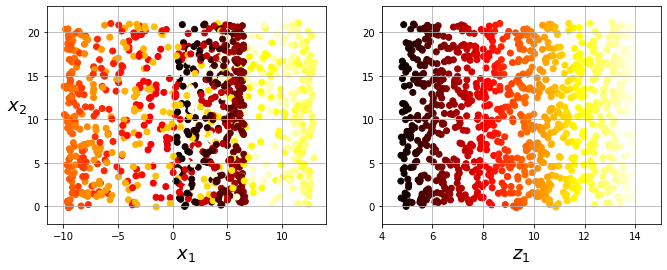

In [30]:
# 스위스 롤 2차원 그래프 그리기
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot) # 2차원 산점도
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0, labelpad=10)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot) # 2차원 산점도(X[:,0] 대신 t 사용)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)
plt.show() # 왼쪽 그래프는 평면에 그냥 투영시킨 것이고, 오른쪽 그림은 매니폴드를 이용하여 평면에 표현한 것

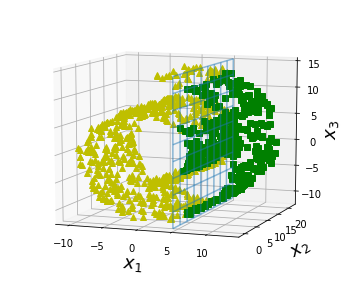

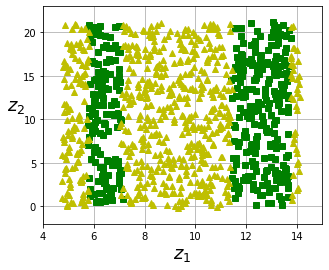

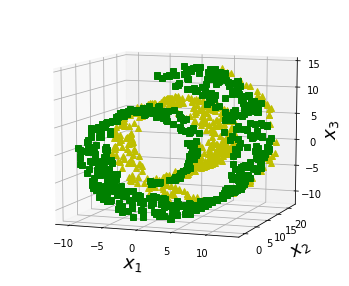

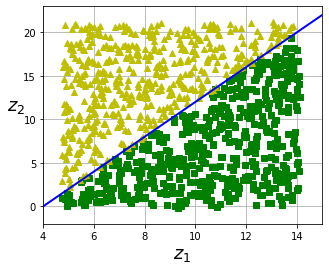

In [31]:
# 저차원에서 항상 간단하지 않은 결정 경계
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5 # 5 초과인 경우 양성으로 설정(매니폴드 저차원의 결정 경계가 어려운 경우)
X_pos = X[positive_class] # 양성 값들
X_neg = X[~positive_class] # 음성 값들
ax.view_init(10, -70) # view_init ==> 바라보는 시야 각도 설정
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^") # 3차원 노란색 세모(음성 클래스)
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs") # 3차원 녹색 네모(양성 클래스)
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs") # 매니폴드 방식으로 2차원 녹색 네모(양성 클래스)
plt.plot(t[~positive_class], X[~positive_class, 1], "y^") # 매니폴드 방식으로 2차원 노란색 세모(음성 클래스)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0, labelpad=7)
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1] # 기존과 다른 방식으로 양성으로 설정(매니폴드 저차원의 결정 경계가 쉬운 경우)
X_pos = X[positive_class] # 양성 값들
X_neg = X[~positive_class] # 음성 값들
ax.view_init(10, -70) # view_init ==> 바라보는 시야 각도 설정
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^") # 3차원 노란색 세모(음성 클래스)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs") # 3차원 녹색 네모(양성 클래스)
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs") # 매니폴드 방식으로 2차원 녹색 네모(양성 클래스)
plt.plot(t[~positive_class], X[~positive_class, 1], "y^") # 매니폴드 방식으로 2차원 노란색 세모(음성 클래스)
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0, labelpad=7)
plt.grid(True)
plt.show() # 매니폴드 방식으로 저차원으로 구성하는 것이 늘 간단한 결정 경계를 갖는 것은 아님

## 8.3 PCA
- 가장 인기 있는 차원 축소 알고리즘으로 데이터에 가장 가까운 초평면을 정의한 다음, 데이터를 이 평면에 투영시키는 것

#### 8.3.1 분산 보존
- 훈련 세트를 투영하기 전 올바른 초평면을 설정해야 하는데 분산을 최대한 보존하여야 함

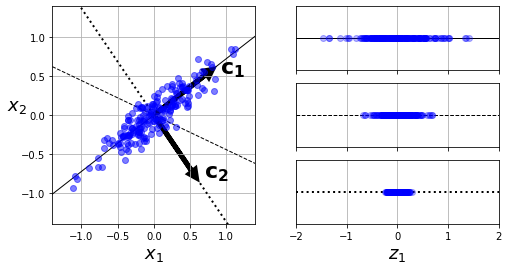

In [32]:
angle = np.pi / 5 # 각도 설정
stretch = 5
m = 200 # sample size

np.random.seed(3)
X = np.random.randn(m, 2) / 10 # 200*2 행렬 생성 후 10으로 나누기
X = X.dot(np.array([[stretch, 0],[0, 1]])) # 1열의 값만 stretch를 곱함
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # angle만큼 회전시킨

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1)) # 투영된 점 좌표1
X_proj2 = X.dot(u2.reshape(-1, 1)) # 투영된 점 죄표2
X_proj3 = X.dot(u3.reshape(-1, 1)) # 투영된 점 좌표3

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3) # 서브 플롯 형태 만들기
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1) # 초평면1 그리기
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1) # 초평면2 그리기
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2) # 초평면3 그리기
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5) # X값들 청색점으로 표시
plt.axis([-1.4, 1.4, -1.4, 1.4]) # 축 범위 설정
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k') # 화살표 그리기
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k') # 화살표 그리기
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22) # 화살표 이름 설정
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22) # 화살표 이름 설정
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True) # 격자 설정

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1) # 초평면1 표시하기
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3) # 투영된 점들 청색점으로 표시
plt.gca().get_yaxis().set_ticks([]) # y축 좌표 값들 표시 없애기
plt.gca().get_xaxis().set_ticklabels([]) # x축 좌표 값들 표시 없애기
plt.axis([-2, 2, -1, 1]) # 축 범위 설정
plt.grid(True) # 격자 설정

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1) # 초평면2 표시하기
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3) # 투영된 점들 청색점으로 표시
plt.gca().get_yaxis().set_ticks([]) # y축 좌표 값들 표시 없애기
plt.gca().get_xaxis().set_ticklabels([]) # x축 좌표 값들 표시 없애기
plt.axis([-2, 2, -1, 1]) # 축 범위 설정
plt.grid(True) # 격자 설정

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2) # 초평면3 표시하기
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3) # 투영된 점들 청색점으로 표시
plt.gca().get_yaxis().set_ticks([]) # y축 좌표 값들 표시 없애기
plt.axis([-2, 2, -1, 1]) # 축 범위 설정
plt.xlabel("$z_1$", fontsize=18) # x축명 설정
plt.grid(True) # 격자 설정
plt.show() # 투영된 값들은 초평면마다 분산이 다르게 유지(아래로 갈수록 분산이 작아짐)

#### 8.3.2 주성분
- PCA는 훈련 세트에서 분산이 최대인 축을 찾은 후, 첫 번째 축에 직교하고 남은 분산을 최대한 보존하는 두 번째 축을 찾고, 두 축에 직교하는 세 번째 축을 찾는 방식으로 훈련 세트의 차원의 수만큼 축을 찾음(그림 같은 경우 1번째 주성분(PC)는 c1, 2번째 주성분(PC)는 c2)
- 훈련 세트의 주성분은 특이값 분해(SVD)라는 표준 행렬 분해 기술을 이용

In [33]:
# 주성분 구하는 방법
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

#### 8.3.3 d차원으로 투영하기
- 주성분을 모두 추출해냈다면 처음 d개의 주성분으로 정의한 초평면에 투영하여 훈련 세트의 차원을 d차원으로 축소시킬 수 있고 이 초평면은 가능한 한 분산을 최대로 보존하는 투영

In [34]:
# 초평면에 훈련 세트를 투영하는 방법
W2 = Vt.T[:, :2] # 2개의 주성분
X2D = X_centered.dot(W2) # 내적을 통해 2차원으로 투영

#### 8.3.4 사이킷런 사용하기
- 사이킷런의 PCA 모델은 자동으로 데이터를 중앙에 맞춰줌(즉, 평균을 0으로 맞추므로 SVD와 같이 원본 데이터에서 평균을 뺄 필요가 없음)

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [36]:
pca.components_[:,0], pca.components_[:,1] # 주성분 (하나씩) 확인

(array([-0.79644131,  0.60471583]), array([-0.60471583, -0.79644131]))

#### 8.3.5 설명된 분산의 비율
- explained_variance_ratio_ 변수에 저장되어 있으며 주성분의 축을 따라 있는 데이터셋의 분산 비율을 나타냄

In [37]:
pca.explained_variance_ratio_ # 사이킷런 방식의 주성분의 분산 비율 확인(제1 주성분 95.4%, 제2 주성분 4.6%)

array([0.95369864, 0.04630136])

#### 8.3.6 적절한 차원 수 선택하기
- 차원의 수를 임의로 정하기보다는 충분한 분산이 될 때까지 더해야 할 차원의 수를 선택하는 쪽이 선호됨(시각화가 목적이라면 보통 2~3차원)

In [38]:
# MNIST 데이터 적절한 차원의 수 확인해보기
from six.moves import urllib # from sklearn.datasets import fetch_mldata // mnist = fetch_mldata('MNIST original')
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [39]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [40]:
# 방법1. 직접 값을 구하기
pca = PCA()
pca.fit(X_train) # 차원의 수를 확인 후 PCA를 할 것이므로 fit만함(trainsform 안함)
cumsum = np.cumsum(pca.explained_variance_ratio_) # cumsum ==> 배열의 누적합 계산
d = np.argmax(cumsum >= 0.95) + 1
d # 차원 수 확인

154

In [41]:
# 방법2. 사이킷런 내부 n_components 이용
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train) # 차원의 수 확인 필요 없으므로 바로 fit_transform
pca.n_components_ # 차원 수 확인

154

In [42]:
np.sum(pca.explained_variance_ratio_) # 분산의 합 확인

0.9504334914295706

#### 8.3.7 압축을 위한 PCA
- MNIST 데이터를 784개에서 154개의 차원으로 축소하면 데이터는 20%만 유지하지만, 분산은 95%를 유지할 수 있음
- 축소된 데이터로 원본의 데이터를 복구할 수 없지만, 거의 비슷할 것임

In [43]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train) # 154개의 주성분으로 PCA
X_recovered = pca.inverse_transform(X_reduced) # PCA 후 복원

In [44]:
# 숫자 그림을 그리는 함수
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row) # 만약 10개 이하면 해당 instances 길이가 행 길이가 됨
    images = [instance.reshape(size,size) for instance in instances] # 모든 이미지 28*28로 바꾼 값 images에 저장
    n_rows = (len(instances) - 1) // images_per_row + 1 # 전체 이미지 행 수 결정
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row] # 행 하나씩 rimages에 저장
        row_images.append(np.concatenate(rimages, axis=1)) # 행 하나씩 열단위로 병합(1행1열 ~ 1행10열 병합)
    image = np.concatenate(row_images, axis=0) # 병합된 행 행단위로 병합(1행 ~ 10행 병합)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'compression restore')

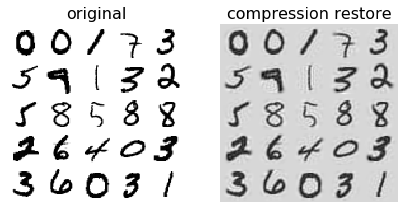

In [45]:
import matplotlib

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100]) # 0부터 끝까지 2100 간격으로 훈련 세트 선택
plt.title("original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100]) # 0부터 끝까지 2100 간격으로 복원 세트 선택
plt.title("compression restore", fontsize=16) # 복원 결과와 조금 손실은 있지만 큰 차이는 없음

In [46]:
X_reduced_pca = X_reduced

#### 8.3.8 점진적 PCA
- PCA 구현의 문제는 SVD 알고리즘을 실행하기 위해 전체 훈련 세트를 메모리에 올려야 함
- 하지만, 점진적 PCA 알고리즘의 개발로 전체 훈련 세트를 메모리에 올리지 않아도 됨
- 훈련 세트를 미니배치로 나눈 뒤 IPCA 알고리즘에 한 번에 하나씩 주입하는 방법으로 훈련 세트가 클 때 유용하며 온라인으로 PCA 적용도 가능

In [47]:
# IncrementalPCA로 점진적 PCA
from sklearn.decomposition import IncrementalPCA # 점진적 PCA 함수

n_batches = 100 # 미니매치 설정
inc_pca = IncrementalPCA(n_components=154) # 154차원으로 설정
for X_batch in np.array_split(X_train, n_batches): # array_split ==> 배열 분리 (X_train을 미니배치 크기 개수대로 분리 - 100개로 분리)
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch) # partial_fit() 매서드를 이용함(미니배치 크기로 PCA)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [48]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced) # 복원하기

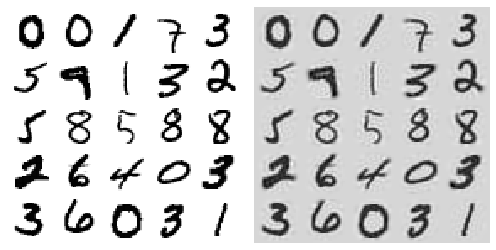

In [49]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100]) # 0부터 끝까지 2100 간격으로 훈련 세트 선택
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100]) # 0부터 끝까지 2100 간격으로 훈련 세트 선택
plt.tight_layout() # tight_layout ==> 그림간 경계 가까이

In [50]:
X_reduced_inc_pca = X_reduced

In [51]:
np.allclose(pca.mean_, inc_pca.mean_) # 일반 PCA와 점진적 PCA의 평균이 같은지 비교(MNIST 데이터에 대하여)

True

In [52]:
np.allclose(X_reduced_pca, X_reduced_inc_pca) # 점진적 PCA는 아주 훌륭한 근사치를 제공하지만 완벽하지는 않음

False

In [53]:
# 넘파이 memmap 클래스로 점진적 PCA(추후 이해 필요함...)
# memmap() 구조를 생성 및 MNIST 데이터를 복사
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [54]:
del X_mm # memmap 객체를 삭제하면 파이썬 종결자(finalizer)를 호출해서 데이터를 디스크에 저장하게 됨

In [55]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches 
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm) # memmap 매서드를 사용하면 일반적인 fit() 매서드를 사용할 수 있음

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [56]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train) # 점진적PCA 적용

#### 8.3.9 랜덤 PCA
- 이 방식은 확률적 알고리즘으로, 첫 d개의 주성분에 대한 근사값을 빠르게 찾음
- 계산 복잡도는 O(m*n^2)+O(n^3)가 아니라 O(m*d^2)+O(d^3) (즉, d가 n보다 많이 작을 경우 매우 빠름)

In [57]:
# 주성분 개수를 바꿔가며 점진적 PCA, 랜덤 PCA에 비해 일반 PCA 시간 비교
import time

for n_components in (2, 10, 154): # 주성분 2, 10, 154
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500) # 미니배치 사이즈=500
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized") # 랜덤 PCA => svd_solver="randomized"

    for pca in (regular_pca, inc_pca, rnd_pca): # 각각의 PCA의 시간 계산
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1)) # 랜덤 PCA가 월등히 빠름

n_components = 2
    PCA: 2.0 seconds
    IncrementalPCA: 20.1 seconds
    PCA: 2.1 seconds
n_components = 10
    PCA: 2.5 seconds
    IncrementalPCA: 22.1 seconds
    PCA: 2.6 seconds
n_components = 154
    PCA: 6.7 seconds
    IncrementalPCA: 27.4 seconds
    PCA: 6.0 seconds


Text(0.5, 1.0, 'Time complexity of PCA and Random PCA')

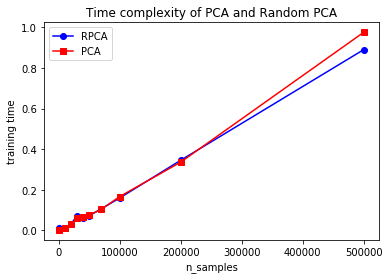

In [58]:
# 데이터셋의 크기(샘플의 수)를 바꾸어가며 일반 PCA와 랜덤 PCA를 비교
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes: # 1000부터 500000 샘플에 따른 PCA(일반, 랜덤) 시간(주성분=2)
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42) # 랜덤 PCA => svd_solver="randomized"
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA") # 랜덤 PCA 청색선
plt.plot(sizes, times_pca, "r-s", label="PCA") # 일반 PCA 적색선
plt.xlabel("n_samples")
plt.ylabel("training time")
plt.legend(loc="upper left")
plt.title("Time complexity of PCA and Random PCA")

Text(0.5, 1.0, 'Time complexity of PCA and Random PCA')

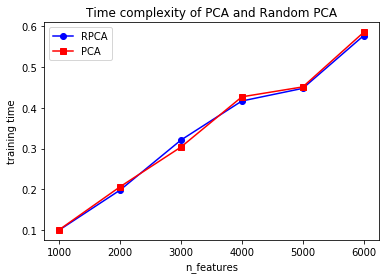

In [59]:
# 특성의 개수를 달리하면서 2,000 샘플이 있는 데이터셋에서 성능을 비교
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes: # 1000부터 6000 특성의 수에 따른 PCA(일반, 랜덤) 시간(주성분=2)
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized") # 랜덤 PCA => svd_solver="randomized"
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA") # 랜덤 PCA 적색선
plt.plot(sizes, times_pca, "r-s", label="PCA") # 일반 PCA 적색선
plt.xlabel("n_features")
plt.ylabel("training time")
plt.legend(loc="upper left")
plt.title("Time complexity of PCA and Random PCA")

## 8.4 커널 PCA
- SVM의 커널 트릭과 같이 차원 축소를 위한 복잡한 비선형 투형을 수행 가능하며 이를 커널 PCA(kPCA)라고 하며 투영된 후에 샘플의 군집을 유지하거나 꼬인 매니폴드에 가까운 데이터셋을 펼칠 때 유용

In [60]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [61]:
from sklearn.decomposition import KernelPCA # 커널 PCA 함수

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04) # RBF 커널
X_reduced = rbf_pca.fit_transform(X) # 커널 PCA 적용

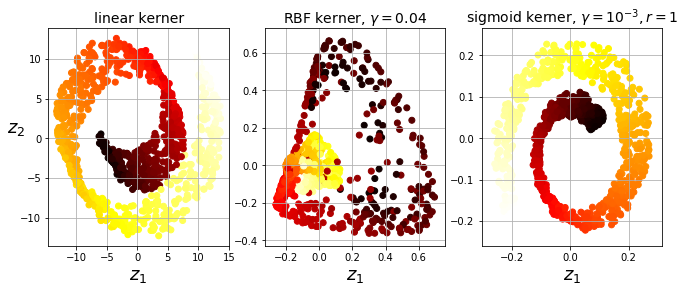

In [62]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True) # 선형 커널
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True) # RBF 커널
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True) # 시그모이드 커널

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "linear kerner"), (132, rbf_pca, "RBF kerner, $\gamma=0.04$"), (133, sig_pca, "sigmoid kerner, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X) # 각각의 커널 적용
    if subplot == 132:
        X_reduced_rbf = X_reduced # 차후 RBF 커널 확인을 위하여 저장
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot) # 차원 축소된 값 2차원으로 표현
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True) # 격자 설정
plt.show()

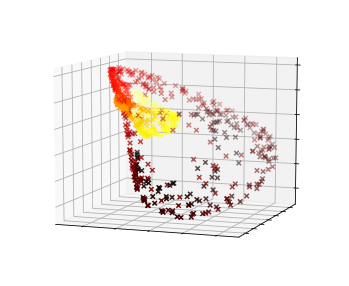

In [63]:
# RBF 커널 PCA 후 복원한 그래프
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf) # RBF 커널 PCA 복원

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x") # 복원된 값 3차원으로 표현
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.show()

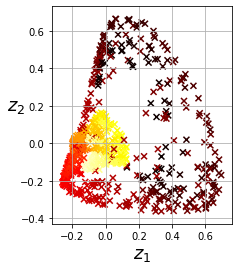

In [64]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

#### 8.4.1 커널 선택과 하이퍼파라미터 튜닝
- kPCA는 비지도 학습으로 좋은 커널과 하이퍼파라미터를 선택하기 위한 명확한 성능 측정 기준이 없지만 종종 전처리 단계로 활용되므로 그리드 탐색을 사용하여 주어진 문제에서 성능이 가장 좋은 하이퍼파라미터를 선택할 수 있음 ==> 주로 파이프 라인 이용
- 완전한 비지도 학습 방법으로, 가장 낮은 재구성 오차를 만드는 커널과 하이퍼파라미터를 선택하는 방식도 있음(단, 재구성은 선형 PCA만큼 쉽지 않음)
- 축소된 공간에 있는 샘플에 대해 선형 PCA를 역전시키면 데이터 포인트는 원본 공간이 아닌 특성 공간에 놓이는데, 이 특성 공간은 무한 차원이므로 재구성된 포인트를 계산할 수 없어 재구성에 따른 실제 에러를 계산할 수 없음 ==> 재구성된 포인트에 가깝게 매핑된 원본 공간의 포인트를 찾을 수 있는데 이를 '재구성 원상'이라 하며 이를 통해 원상을 얻게 되면 원본 샘플과의 제곱 거리를 측정 가능함

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver='liblinear'))
    ]) # 파이프라인 생성(PCA -> 모델 적용)

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }] # 그리드 파라미터로 kPCA 하이퍼파라미터 설정

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y) # 그리드 서치 적용

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

In [66]:
print(grid_search.best_params_) # 최적 하이퍼파라미터값 확인

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [67]:
# inverse_transform ==> 투영된 샘플을 훈련 세트로, 원본 샘플을 타깃으로 하는 지도 학습 회귀 모델을 훈련시키는 것(커널 릿지 회귀 기반)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True) # 최적값 저장
X_reduced = rbf_pca.fit_transform(X) # kPCA 적용
X_preimage = rbf_pca.inverse_transform(X_reduced) # kPCA 복원

In [68]:
# 재구성 원상 오차 계산(재구성 원상 오차를 최소화하는 하이퍼파라미터와 커널을 찾기 위한 교차 검증으로 그리드 서치 이용 가능)
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage) # kPCA 후 복원 데이터와 원본 데이터의 MSE 측정

32.78630879576614

## 8.5 LLE (지역 선형 임베딩)
- 지역 선형 임베딩은 또 다른 강력한 비선형 차원 축소 기술로 투영에 의존하지 않는 매니폴드 학습
- 1. 각 훈련 샘플이 가장 가까운 K개의 이웃에 얼마나 선형적으로 연관되어 있는지 측정
- 2. 국부적인 관계가 가장 잘 보존되는 훈련 세트의 저차원 표현을 찾음(잡음이 너무 많지 않은 경우 꼬인 매니폴드를 펼치는데 잘 작동)
- 사이킷런이 제공하는 LLE 구현의 계산 복잡도는 k개의 가까운 이웃을 찾는데 O(m*log(m)*n*log(k)), 가중치 최적화의 O(m*n*k^3), 저차원 표현을 만드는 데 O(d*m^2)이고 저차원 표현을 만드는 계산량 m^2 때문에 대량의 데이터셋에는 적용하기 힘듬

In [69]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41) # 스위스 롤 데이터 생성

In [70]:
from sklearn.manifold import LocallyLinearEmbedding # LLE

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

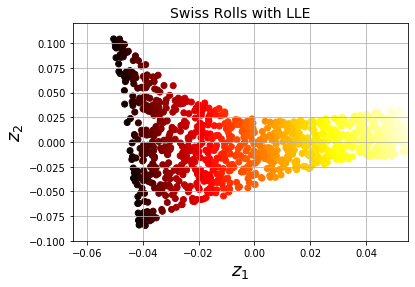

In [71]:
plt.title("Swiss Rolls with LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
plt.show()

#### 설명: 스위스 롤이 완전히 펼쳐졌고 지역적으로는 샘플 간 거리가 잘 보존되어 있다. 그러나 크게 보면 샘플 간 거리가 잘 유지되어 있지 않은데, 펼쳐진 스위스 롤의 오른쪽은 압축되어 있고 왼쪽은 확장되어 있다. 그럼에도 불구하고 LLE는 매니폴드를 모델링하는데 잘 작동한다.

## 8.6 다른 차원 축소 기법

In [72]:
# 다차원 스케일링: 샘플 간 거리를 보존하면서 차원을 축소
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [73]:
# Isomap: 각 샘플을 가장 가까운 이웃과 연결하는 식으로 그래프를 만든 후, 샘플 간의 지오데 거리를 유지하며 축소
# 지오데 거리는 그래프에서 두 노드 사이의 최단 경로를 이루는 노드의 수를 의미
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [74]:
# t-SNE: 비슷한 샘플은 가까이 비슷하지 않은 샘플은 멀리 떨어지도록 하면서 차원을 축소하는데 주로 시각화에 많이 사용
# 특히 고차원 공간에 있는 샘플의 군집을 시각화할 때 사용(예를 들어 MNIST 데이터셋을 2D로 시각화 할 때)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [75]:
# 선형 판별 분석: 분류 알고리즘이나 훈련 과정에서 클래스 사이를 가장 잘 구분하는 축을 학습하여 초평면 정의하는데 사용할 수 있음
# 이 알고리즘의 장점은 투영을 총해 가능한 한 클래스가 멀리 떨어지도록 유지시키므로 SVM 분류기 같은 알고리즘을 사용할 때 차원축소로 유용
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = X # mnist["data"]
y_mnist = y # mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(3, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


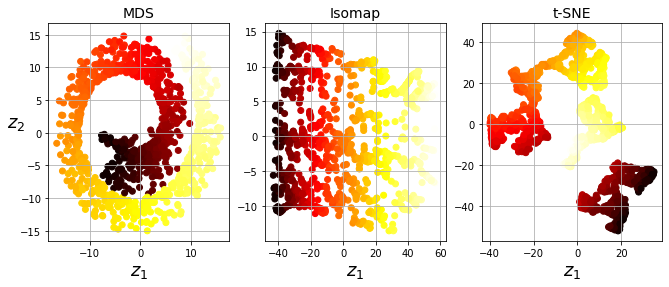

In [76]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles, (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)
plt.show()

## 8.7 연습문제

#### 1. 데이터셋의 차원을 축소하는 주요 목적은 무엇인가요? 대표적인 단점은 무엇인가요?
- 장점1: 훈련 알고리즘의 속도를 높이기 위해(어떤 경우에는 잡음과 중복된 특성을 삭제할 수도 있어 훈련 알고리즘의 성능을 높임)
- 장점2: 데이터를 시각화하고 가장 중요한 특성에 대해 통찰을 얻기 위해
- 장점3: 메모리 공간을 절약하기 위해(압축)
- 단점1: 일부 정보를 잃어버려 훈련 알고리즘의 성능을 감소시킬 수 있음
- 단점2: 계산 비용이 높음
- 단점3: 머신러닝 파이프라인의 복잡도를 증가시킴
- 단점4: 변환된 데이터를 이해하기 어려운 경우가 많음

#### 2. 차원의 저주란 무엇인가요?
- 차원의 저주는 저차원 공간에는 없는 많은 문제가 고차원 공간에서 일어난다는 사실을 뜻한다. 머신러닝에서 무작위로 선택한 고차원 벡터는 매우 희소해서 과대적합 위험이 크고, 많은 양의 데이터가 있지 않으면 데이터에 있는 패턴을 잡아내기 매우 어려운 것이 흔한 현상

#### 3. 데이터셋의 차원을 축소시키고 나서 이 작업을 원복할 수 있나요? 할 수 있다면 어떻게 가능할까요? 가능하지 않다면 왜일까요?
- 여기서 설명한 알고리즘 중 하나를 사용해 데이터셋의 차원이 축소되면 일부 정도바 차원 축소 과정에서 사라지기 때문에 이를 완벽하게 되돌리는 것은 불가능하다. (PCA같은) 일부 알고리즘은 비교적 원본 데이터와 비슷한 데이터셋을 재구성할 수 있는 간단한 역변환 방법을 가지고 있지만, (t-SNE같은) 다른 알고리즘은 그렇지 않다.

#### 4. 매우 비선형적인 데이터셋의 차원을 축소하는 데 PCA를 사용할 수 있을까요?
- PCA는 불필요한 차원을 제거할 수 있기 때문에 매우 비선형적이더라도 대부분의 데이터셋에서 차원을 축소하는 데 사용할 수 있습니다. 그러나 불필요한 차원이 없다면(예를 들어 스위스 롤 데이터셋) PCA의 차원 축소는 너무 많은 정보를 잃게 만든다. 즉, 스위스 롤은 펼쳐야 하며 말려진 것을 뭉게면 안된다.

#### 5. 설명한 분산을 95%로 지정한 PCA를, 1,000개의 차원을 가진 데이터셋에 적용한다고 가정하겠습니다. 결과 데이터셋의 차원은 얼마나 될까요?
- 이 질문에는 속임수가 있습니다. 답은 데이터셋에 따라 다릅니다. 극단적인 두 가지의 사례를 생각해보겠습니다. 먼저 거의 완벽하게 일렬로 늘어선 데이터 포인트로 구성된 데이터셋을 생각해보겠습니다. 이 경우 PCA는 분산의 95%를 유지하면서 데이터셋을 단 하나의 차원으로 줄일 수 있습니다. 이번에는 완전히 무작위로 1,000개의 차원에 걸쳐 흩어져 있는 데이터셋을 생각해보겠습니다. 이 경우 분산의 95%를 보존하려면 거의 950개의 차원이 필요할 것입니다. 그러므로 답은 데이터셋에 따라 달라지고 1에서 950 사이의 어떤 수도 될 수 있습니다. 차원 수에 대한 함수로 설명된 분산의 그래프를 그려보는 것이 데이터 셋에 내재된 차원 수를 대략 가늠할 수 있는 한 가지 방법입니다.

#### 6. 기본 PCA, 점진적 PCA, 랜덤 PCA, 커널 PCA는 어느 경우에 사용될까요?
- 기본 PCA가 우선적으로 사용되지만 데이터셋 크기가 메모리에 맞을 때에 가능합니다. 점진적 PCA는 메모리에 담을 수 없는 대용량 데이터셋에 적합합니다. 하지만 기본 PCA보다 느리므로 데이터셋이 메모리 크기에 맞으면 기본 PCA를 사용해야 합니다. 점진적 PCA는 새로운 샘플이 발생될 때마다 실시간으로 PCA를 적용해야 하는 온라인 작업에 사용 가능합니다. 랜덤 PCA는 데이터셋이 메모리 크기에 맞고 차원을 크게 축소시킬 때 사용됩니다. 이 경우에는 기본 PCA보다 훨씬 빠릅니다. 커널 PCA는 비선형 데이터셋에 유용합니다.

#### 7. 어떤 데이터셋에 적용한 차원 축소 알고리즘의 성능을 어떻게 평가할 수 있을까요?
- 직관적으로 데이터셋에서 너무 많은 정보를 잃지 않고 차원을 많이 제거할 수 있다면 차원 축소 알고리즘이 잘 작동한 것입니다. 이를 측정하는 한 가지 방법은 역변환을 수행해서 재구성 오차를 측정하는 것입니다. 하지만 모든 차원 축소 알고리즘이 역변환을 제공하지는 않습니다. 만약 차원 축소를 다른 머신러닝 알고리즘을 적용하기 전에 전처리 단계로 사용한다면 두 번째 알고리즘의 성능을 측정해볼 수 있습니다. 즉, 차원 축소가 너무 많은 정보를 잃지 않았다면 원본 데이터셋을 사용했을 때와 비슷한 성능이 나와야 합니다.

#### 8. 두 개의 차원 축소 알고리즘을 연결할 수 있을까요?
- 당연히 두 개의 차원 축소 알고리즘을 연결할 수 있습니다. PCA로 불필요한 차원을 대폭 제거하고 난 다음 LLE 같이 훨씬 느린 알고리즘을 적용하는 것이 대표적인 사례입니다. 이런 2단계 방식은 LLE만 사용했을 때와 거의 비슷한 성능을 내기만 속도가 몇 분의 1로 줄어들 것입니다.

#### 9. MNIST 데이터셋을 로드하고 훈련 세트와 테스트 세트로 분할합니다. 이 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 시간을 잰 다음, 테스트 세트로 만들어진 모델을 평가합니다. 그런 다음 PCA를 사용해 설명된 분산이 95%가 되도록 차원을 축소합니다. 이 축소된 데이터셋에 새로운 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 확인합니다. 훈련 속도가 더 빨라졌나요? 이제 테스트 세트에서 이 분류기를 평가해보세요. 이전 분류기와 비교해서 어떤가요?

#### 10. t-SNE 알고리즘을 사용해 MNIST 데이터셋을 2차원으로 축소시키고 맷플롯립으로 그래프를 그려보세요. 이미지 타깃 클래스마다 10가지 색깔로 나타낸 산점도를 그릴 수 있습니다. 또는 샘플의 위치에 각기 다른 색깔의 숫자를 나타낼 수도 있고, 숫자 이미지 자체의 크기를 줄여서 그릴수도 있습니다. 잘 분리된 숫자의 군집을 시각화할 수 있을 것입니다. PCA, LLE, MDS 같은 차원 축소 알고리즘을 적용해보고 시각화 결과를 비교해보세요.